# Import needed modules and useful functions

In [1]:
#-- useful python script to compute the TICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias_A/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2
psi: TORSION ATOMS=@psi-2
ene: ENERGY

INCLUDE FILE=plumed_descriptors.data

PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp ../script/input.* ../script/plumed_descriptors.data "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

Text(0, 0.5, '$\\psi$')

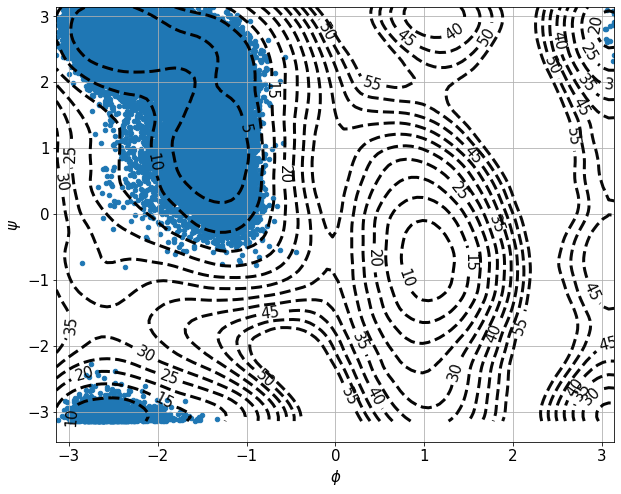

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

In [61]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'lag_time':8,#1,4,8
              'standardize_outputs':True,
              'standardize_inputs': True,
              #if reweight the timescale
              "reweighting": False,
              "step": 20 #se prendo tutti i valori fallisce il cholesky decomposition.. issue con pytorch
              }
#--------------------------------------#

In [41]:
lags = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,25]
time = []
torch.manual_seed(21)
timescale = np.empty(len(lags))
for i,lag in enumerate(lags):
    train_parameters["lag_time"] = lag
    #print("lag time ", lag)
    model,data,logweight,X,names = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

    #-- move the model back to cpu for convenience --# 
    model.to('cpu')

    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]

no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights
no weights


[1.16124642 0.16621214 0.33047527 0.37903559 0.24208236 0.15772688
 0.39316291 0.55947787 0.21914452 0.12275302 0.0133841  0.00919166
 0.04704487 0.01891276 0.01767984 0.02701481 0.02944086]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 25]


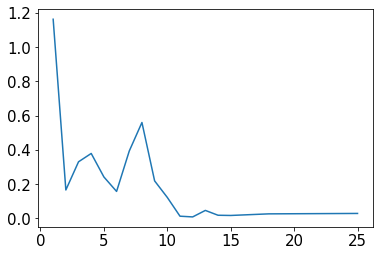

In [45]:
plt.plot(lags,timescale)
print(timescale)
print(lags)

## DeepTICA Analysis and Export

In [72]:
torch.manual_seed(21)
model,data,logweight,X,names = training(sim_parameters["beta"],folder+"COLVAR",train_parameters,tprime=None)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

model.set_params({"feature_names": names})
print( model.plumed_input() )

no weights
timescales:  [-40.614697   19.129795   18.510567   18.244295   18.054796   17.818512
  17.774612   17.401886   17.175951   17.08999    17.043447   16.964922
  16.78658    16.588356   16.473944   16.403454   16.352192   16.08416
  16.067045   16.04301    15.875118   15.785058   15.66703    15.625139
  15.585655   15.392671   15.342231   15.26749    15.059564   15.016246
  14.932618   14.763669   14.6799345  14.640472   14.538999   14.418298
  14.377589   14.32064    14.268427   14.058804   13.804241   13.73763
  13.5726795  12.785902    9.267306 ]
eigenvalues:  [1.2177112  0.65823334 0.6490889  0.64500755 0.64204586 0.63828444
 0.63757706 0.63146025 0.6276532  0.62618446 0.6253845  0.62402725
 0.62090874 0.6173828  0.6153184  0.6140357  0.61309767 0.60811955
 0.60779744 0.60734427 0.6041497  0.6024152  0.60011953 0.59929854
 0.5985217  0.59468234 0.5936671  0.5921536  0.587885   0.5869848
 0.5852361  0.58165914 0.5798641  0.57901293 0.5768089  0.5741581
 0.5732568  0.5719897 

#### Adding to data the cvs values

In [63]:
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

In [64]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data["cv3"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[2]
data["cv4"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[3]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]
data_complete["cv3"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[2]
data_complete["cv4"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[3]

<AxesSubplot:ylabel='Frequency'>

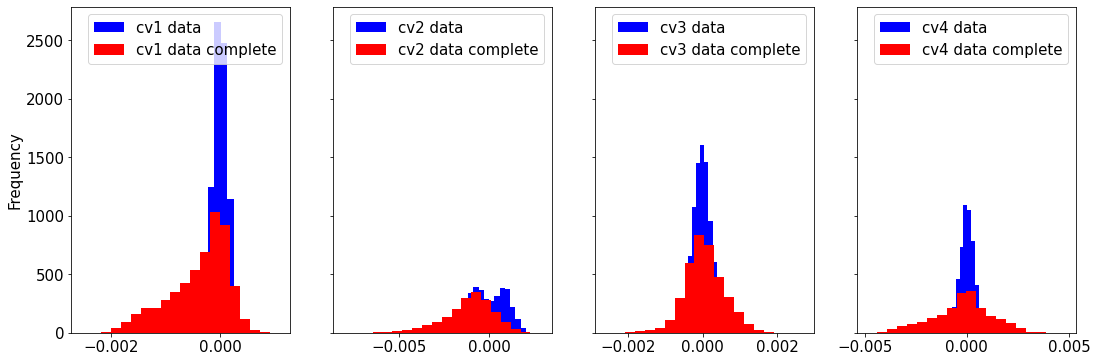

In [65]:
fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b",label="cv1 data")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b",label="cv2 data")
data.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="b",label="cv3 data")
data.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="b",label="cv4 data")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="r",label="cv1 data complete")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r",label="cv2 data complete")
data_complete.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="r",label="cv3 data complete")
data_complete.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="r",label="cv4 data complete")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

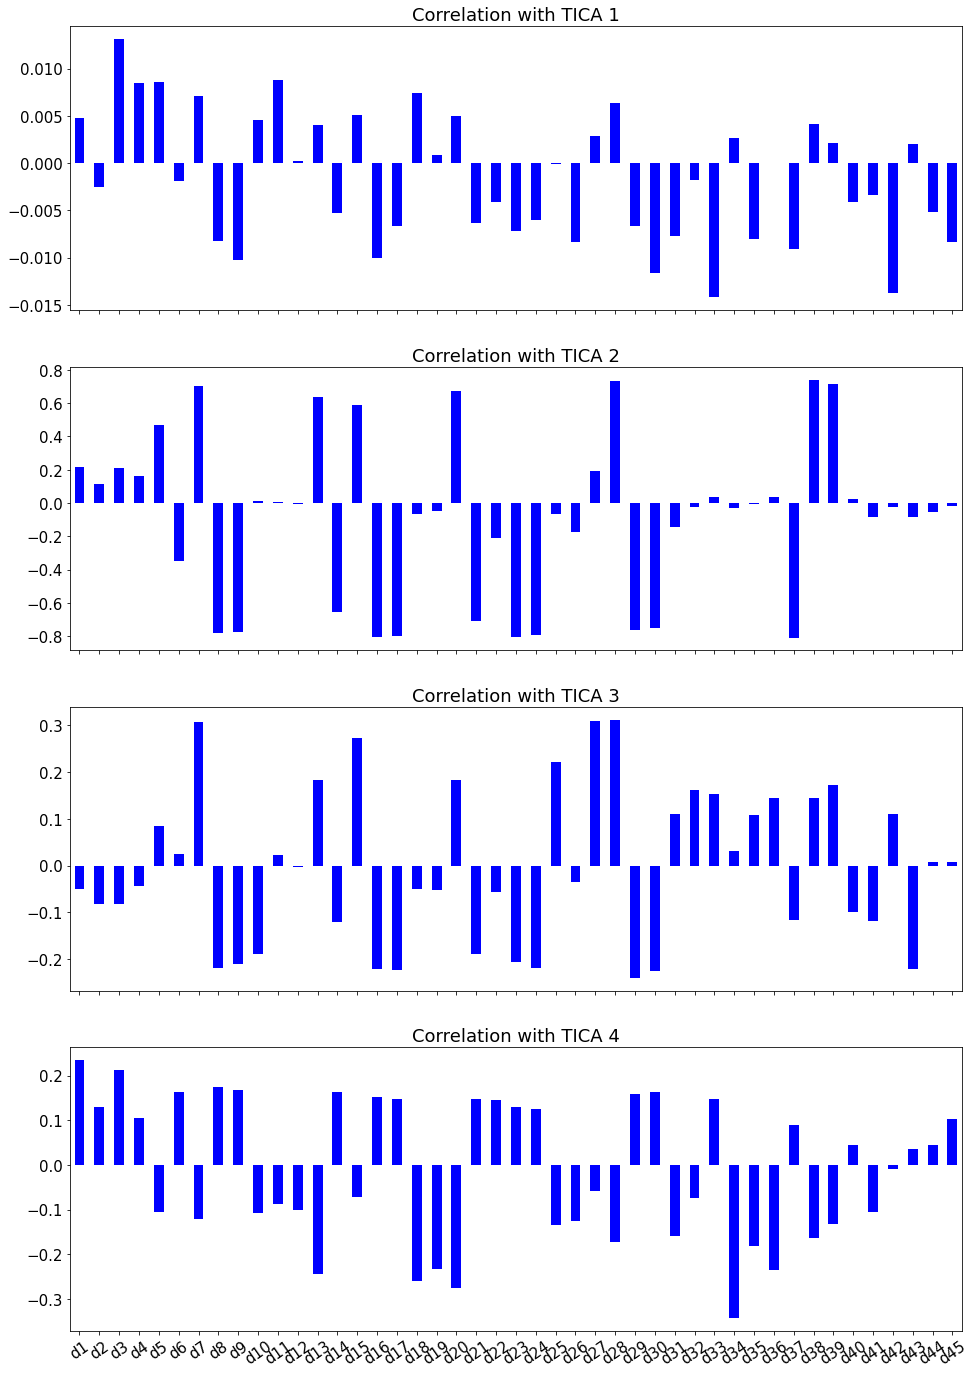

In [66]:
fig,axs = plt.subplots(4,1,figsize=(16,24),sharex=True)
for k,cv in enumerate(["cv1","cv2","cv3","cv4"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(tica|desc)$")
    axs[k].set_title('Correlation with TICA '+str(k+1))
plt.show()

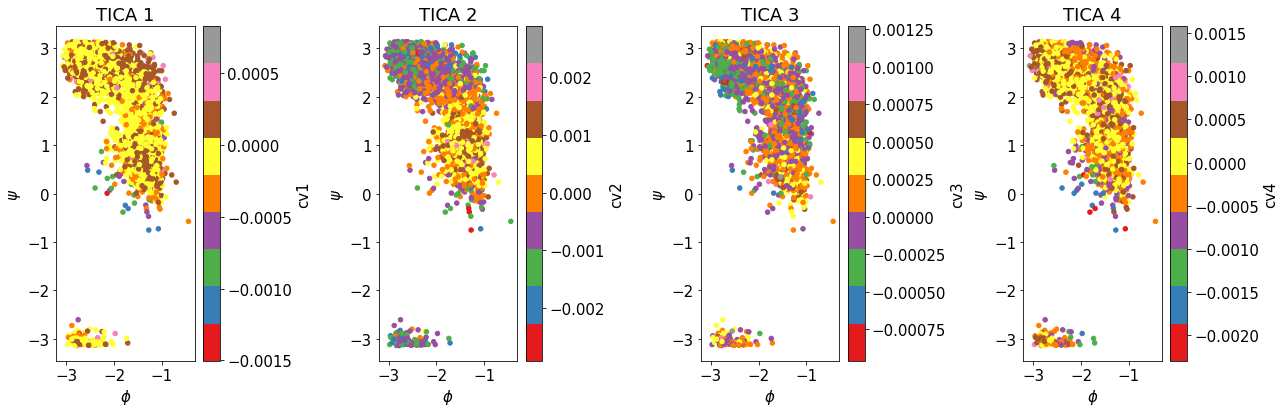

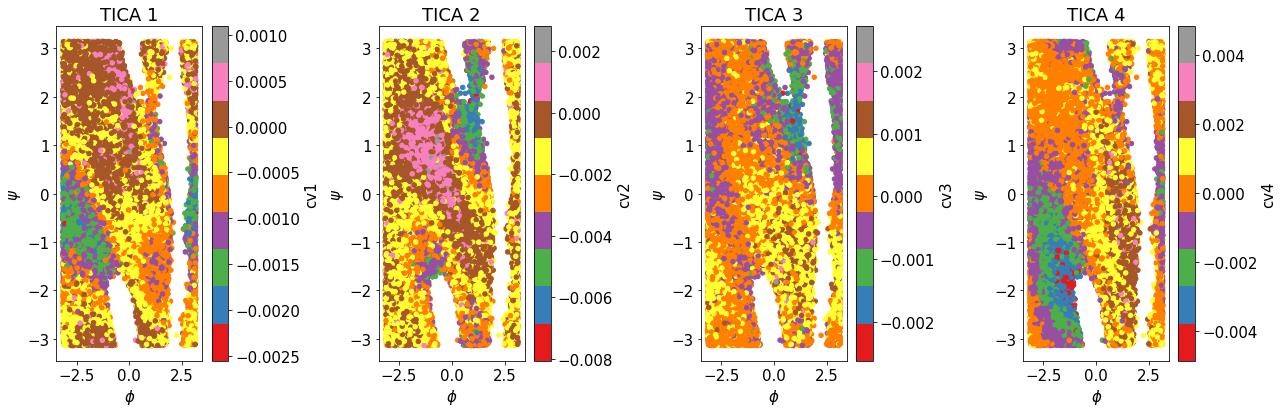

In [67]:
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [68]:
Boltzmann_product(model,model,X,j=0,k=1)

8.194699305817625e-10

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [69]:
#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X)
prod = np.multiply(np.multiply(cv1,np.ones(X.shape[0])),new_cv2).mean()
print(prod)

-5.226253327186468e-18


Text(0.5, 1.0, 'TICA 2 orthogonal')

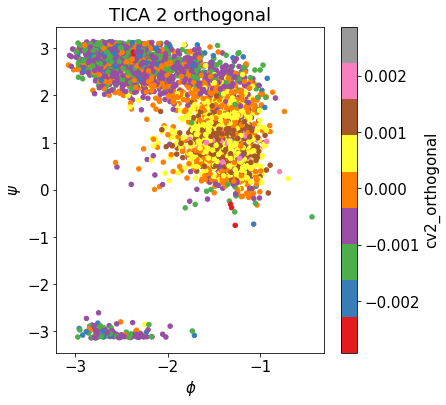

In [70]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="psi",x="phi",c="cv2_orthogonal",cmap="Set1",ax=ax)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")
ax.set_title('TICA 2 orthogonal')